In [203]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

In [204]:
sns.set_context('notebook',font_scale=2.0)#,rc={'savefig.bbox':'tight'})
mpl.rcParams['savefig.bbox'] = 'tight'

### Load in the data

In [205]:
with open('bepipred3.json') as fi:
    data = json.load(fi)

### Print the length of data and the keys for the first datapoint

In [206]:
print(len(data))
print(data[0].keys())

190
dict_keys(['asa', 'desc', 'disorder', 'epitope', 'id', 'interface', 'method', 'phi', 'preds', 'psi', 'q3', 'q3_prob', 'q8', 'q8_prob', 'rsa', 'seq'])


### Print the keys and length of values for the first datapoint.

In [244]:
for key,val in data[0].items():
    print(key)
    print(len(val),type(val))

asa
136 <class 'list'>
desc
11 <class 'str'>
disorder
136 <class 'list'>
epitope
136 <class 'list'>
id
12 <class 'str'>
interface
136 <class 'list'>
method
7 <class 'str'>
phi
136 <class 'list'>
preds
136 <class 'list'>
psi
136 <class 'list'>
q3
136 <class 'str'>
q3_prob
136 <class 'list'>
q8
136 <class 'str'>
q8_prob
136 <class 'list'>
rsa
136 <class 'list'>
seq
136 <class 'str'>


### A function that extracts selected features from a JSON entry and places them in a pandas dataframe. Entries/dataframes merged into a master DF

In [208]:
#features = ['asa','disorder','epitope','interface','phi','psi','preds','rsa','q3_prob','seq']
def extractFeatures(data):
    features = ['epitope','preds','seq','desc']
    feats = list(map(lambda feat:data[feat], features))
    feats = dict(zip(features,feats))
    feats['seq'] = list(feats['seq'])
    feats['desc'] = [feats['desc']]*len(feats['preds'])
    try:
        return pd.DataFrame(feats,columns=features)
    except ValueError:
        return []

dfList = list(map(extractFeatures,data))
dfList = list(filter(lambda x:len(x)>0,dfList))#Examples of when epitope feature does not match in length???
df_master = pd.concat(dfList)

### Density plots for prediction scores, colored by the amino acid type. There is clearly a difference in means of the distributions!

In [227]:
sns.set_palette(sns.color_palette("hls", 20))

Epitope Status: 0.0


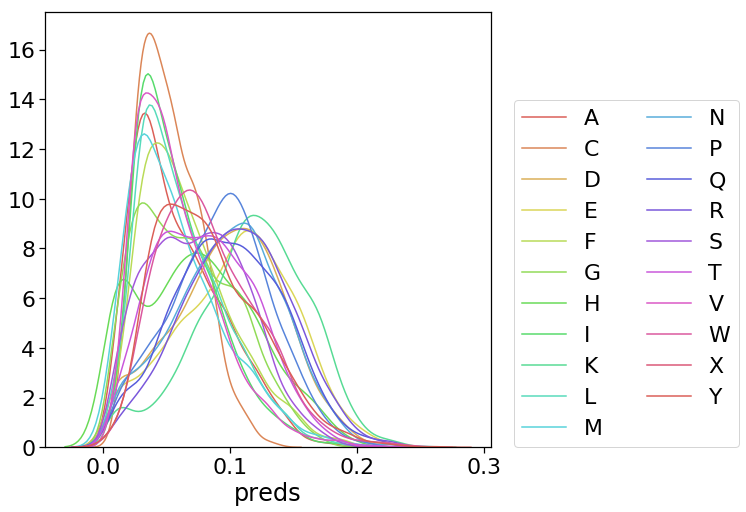

Epitope Status: 1.0


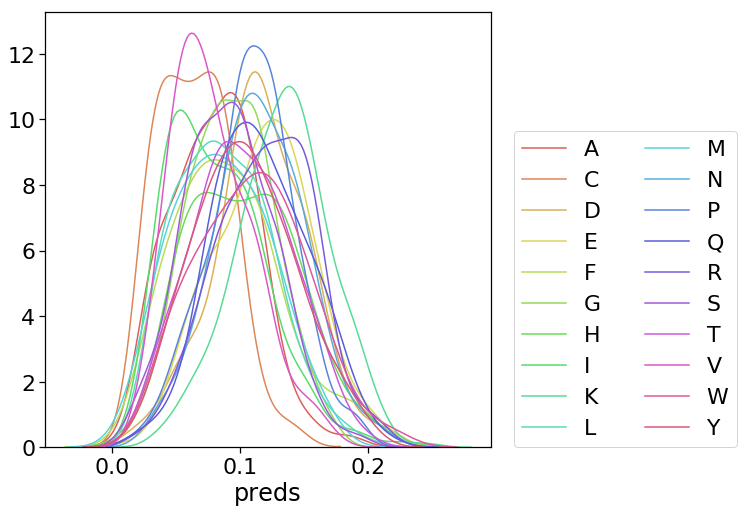

In [228]:
def plotAApredDistrib(df,groupCol='seq'):
    plt.figure(figsize=(8,8))
    for group in df.groupby(groupCol):
        sns.distplot(group[1].preds,hist=False,label=group[0])
    plt.legend(loc=[1.05,0],ncol=2)    
    plt.show()
    
for group in df_master.groupby('epitope'):
    print("Epitope Status: %.1f"%group[0])
    plotAApredDistrib(group[1])

### Comparing prediction score distributions for epitopes and background of amino acids.
There is also a difference in the overlap of the positive and negative distributions for amino acids. Indicating that the method is better at decerning between epitopes and background for some amino acids.

Amino acid: A


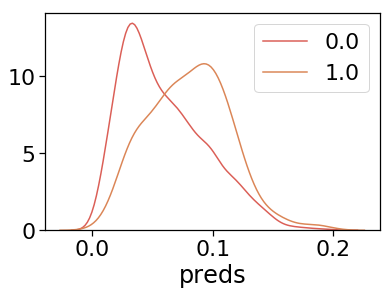

Amino acid: C


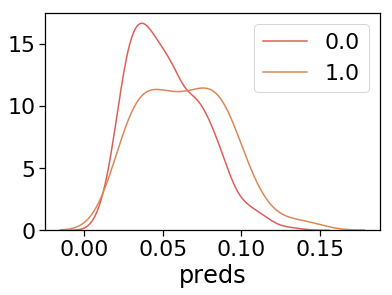

Amino acid: D


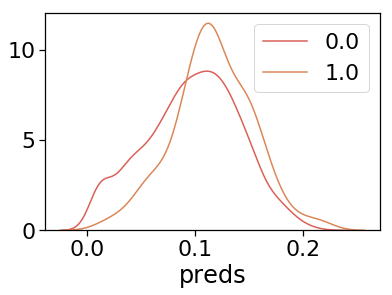

Amino acid: E


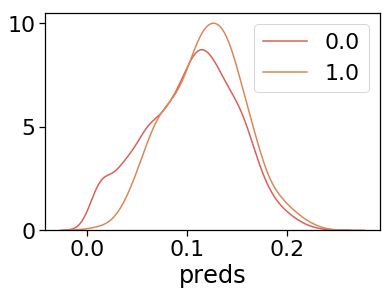

Amino acid: F


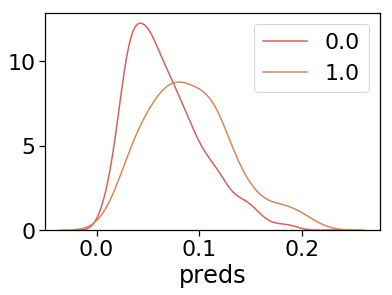

Amino acid: G


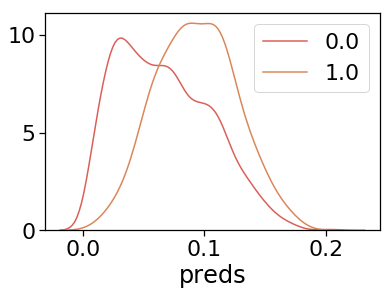

Amino acid: H


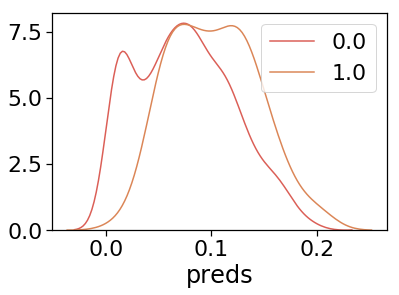

Amino acid: I


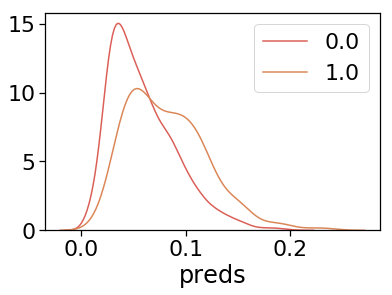

Amino acid: K


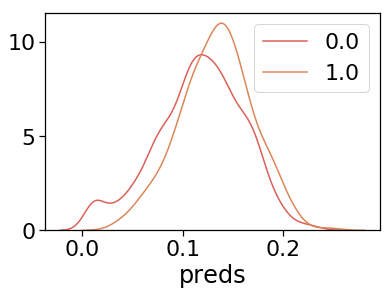

Amino acid: L


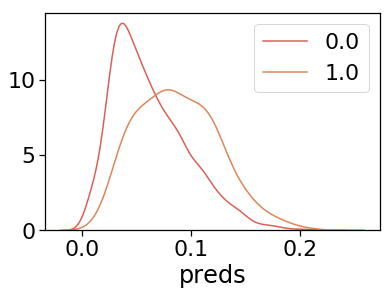

Amino acid: M


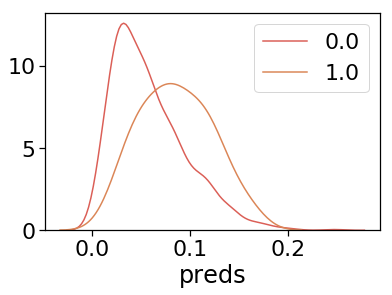

Amino acid: N


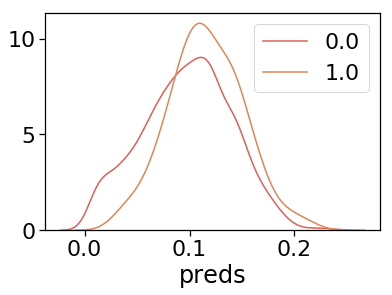

Amino acid: P


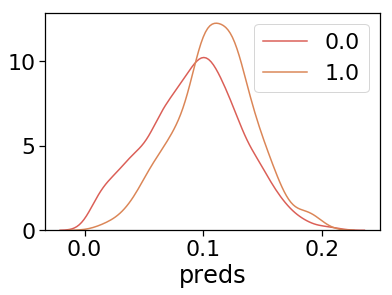

Amino acid: Q


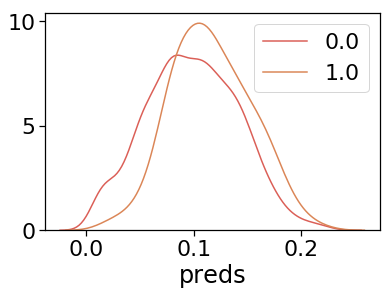

Amino acid: R


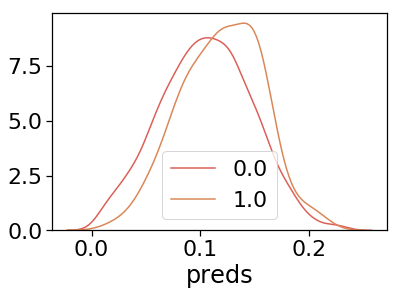

Amino acid: S


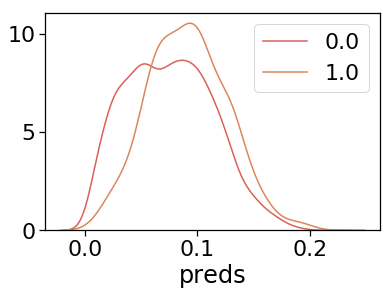

Amino acid: T


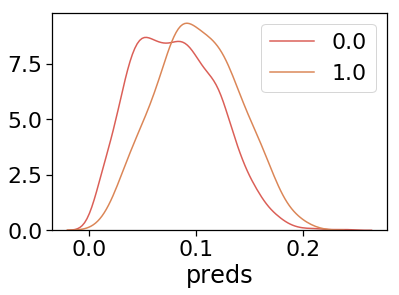

Amino acid: V


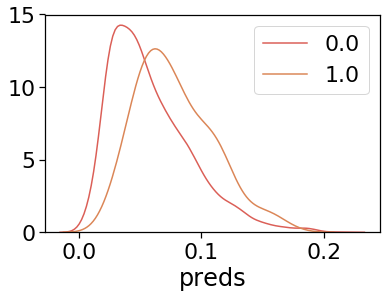

Amino acid: W


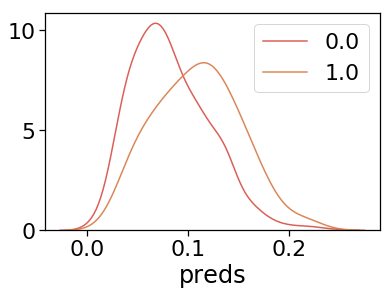

Amino acid: X


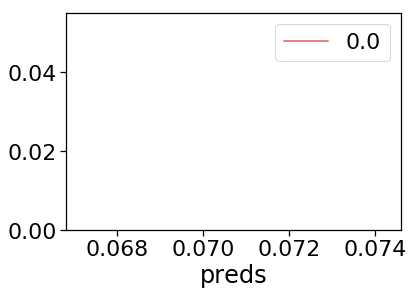

Amino acid: Y


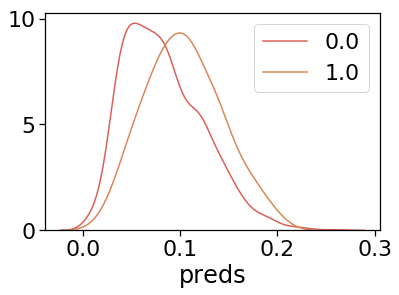

In [229]:
def comparePosNegDistrib(df,seqCol='seq',epiCol='epitope'):
    for group in df.groupby(seqCol):
        print("Amino acid: %s"%group[0])
        for group1 in group[1].groupby(epiCol):
            sns.distplot(group1[1].preds,hist=False,label=group1[0])
        plt.show()
comparePosNegDistrib(df_master)

### Comparing mean prediction score for epitopes and background for amino acids
Every point of the scatter plot falls above the identity line, indicating that for every amino acid, the mean prediction score for epitopes is higher than for non epitopes.

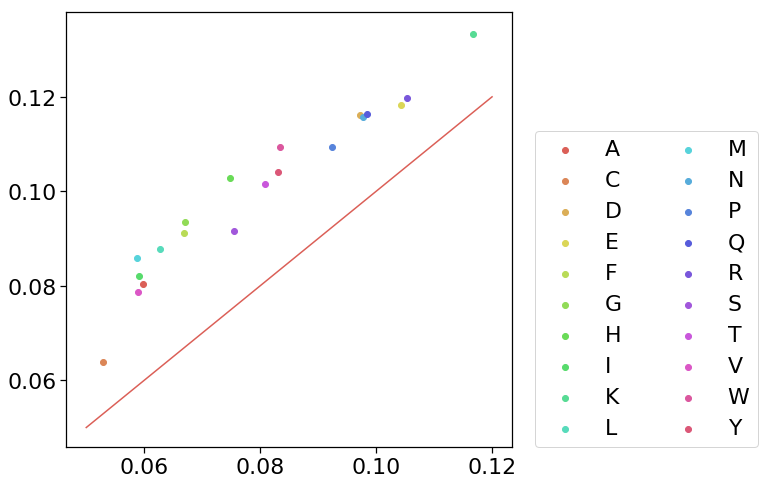

preds           AA
epitope       0.0       1.0   
seq                           
A        0.059715  0.080330  A
C        0.052956  0.063943  C
D        0.097269  0.116110  D
E        0.104348  0.118365  E
F        0.066895  0.091230  F
G        0.067007  0.093470  G
H        0.074833  0.102760  H
I        0.059149  0.082060  I
K        0.116701  0.133264  K
L        0.062647  0.087796  L
M        0.058745  0.085905  M
N        0.097699  0.115767  N
P        0.092430  0.109337  P
Q        0.098381  0.116260  Q
R        0.105335  0.119776  R
S        0.075408  0.091526  S
T        0.080751  0.101558  T
V        0.058887  0.078606  V
W        0.083392  0.109359  W
Y        0.082994  0.104027  Y

In [231]:
df_meanPred = df_master.groupby(['epitope','seq'])['preds'].mean()

df_meanPred = df_meanPred.reset_index()
df_meanPred = df_meanPred.pivot(columns='epitope',index='seq')
df_meanPred = df_meanPred.dropna()
df_meanPred['AA'] = df_meanPred.index

val = df_meanPred.values

plt.figure(figsize=(8,8))
for i,j,k in val:
    plt.scatter(i,j,label=k)
plt.legend(loc=[1.05,0],ncol=2)

plt.plot([0.05,0.12],[0.05,0.12])#Plot identity line for comparison
plt.show()

df_meanPred

### Logistic regression analysis
Incomplete...

In [167]:
def splitPartitions(df,descCol='desc',testSet=1):
    cols = df.columns
    df['part'] = list(map(lambda x:int(x.split(' ')[-1]),df[descCol].values))
    df_test = df[df['part']==testSet]
    df_train = df[df['part']!=testSet]
    return df_test[cols], df_train[cols]

df_test, df_train = splitPartitions(df_master)

In [171]:
from sklearn.linear_model import LogisticRegression

def getData(df,xCol='preds',yCol='epitope'):
    x = df[xCol].values
    x = x.reshape(-1,1)
    y = df[yCol]
    return x,y

x_test,y_test = getData(df_test)
x_train,y_train = getData(df_train)

clf = LogisticRegression(random_state=0, solver='lbfgs',).fit(x, y)
clf.score(x, y)
pred = clf.predict(x_test)


In [175]:
for i,j in zip(y_test,pred):
    print(i,j)

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
